In [45]:
from collections import defaultdict
from os import listdir
from os.path import isfile, join
import re
import pandas as pd
import numpy as np
import math
from itertools import cycle, product
from scipy.stats import poisson
from numpy import vectorize
import multiprocessing
from joblib import Parallel, delayed
import matplotlib.pyplot as plt 

from utilities import *
from helper_functions import *
from input_functions import get_datadirs, read_input_data, concantenate_data
from data_processing import bucket_spikes, bucket_location, x_round
from data_analysis import estimate_place_fields
from parameter_estimation import fit_diffusion_model, fit_random_walk_model, fit_random_walk_model_no_boundaries
from filtering_algorithms import diffusion_pf, random_walk_pf

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
TIME_BUCKET_LENGTH = .1
LOCATION_BUCKET_LENGTH = .2 # length is 1/LOCATION_BUCKET_LENGTH

In [3]:
animal_dirs = get_datadirs()
dirs = [item for sublist in animal_dirs.values() for item in sublist]
data = read_input_data(dirs)

concantenated_data = concantenate_data(data)

## Bucketing Data into Time and Location Bins

In [4]:
bucketed = {}
# average time between spikes is 0.002s, time between location measurements is 0.02s
dt = 0.1
dL = 0.01
times = [dt]
lengths = [dL]
for time, length, directory in product(times, lengths, dirs):
    if (time, length, directory) not in bucketed:
        bucketed_spikes = bucket_spikes(concantenated_data[directory], time)
        locs, bucketed_locs = bucket_location(data[directory]['location'], time, length)

        bucketed_spikes['location'] = bucketed_locs[0]
        bucketed_spikes['unbucketed_location'] = locs[0]
        bucketed_spikes = bucketed_spikes.dropna()
        bucketed[time, length, directory] = bucketed_spikes

In [5]:
df = bucketed[dt, dL, 'data/ec013.40/ec013.719/']

In [6]:
spikes = np.array(df.loc[:,df.columns[:-2]])
spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])

T = len(df) * dt
L = int(df.location.max() + 5)
xaxis = np.arange(0,L,dL) + dL/2 # center of bins
find_nearest = np.vectorize(lambda x: fn(xaxis, x))
M = spikes.shape[1]

X = np.array(df.unbucketed_location)
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])

_, smoothed_place_fields = estimate_place_fields(spikes_train, X_train, xaxis, dt)

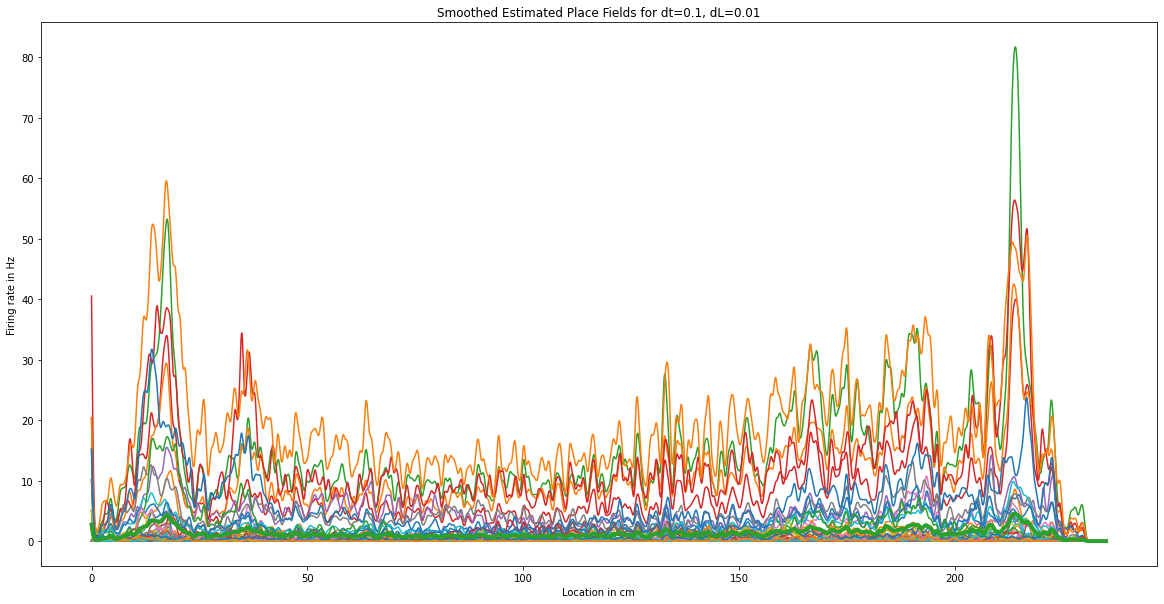

In [7]:
plt.plot(xaxis,np.transpose(smoothed_place_fields))
plt.plot(xaxis,np.sum(smoothed_place_fields,0)/M,linewidth=4)
plt.title("Smoothed Estimated Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

In [10]:
sigma = fit_diffusion_model(X_train, dt)

In [46]:
P = 10000
Peff_min = 0.5

params = {
    "sigma": sigma,
    "smoothed_place_fields":smoothed_place_fields,
    "dt": dt,
    "xaxis": xaxis, # axis for placefields
    "dL": dL,
    "T": T,
    "P": P,
    "Peff_min": Peff_min,
    "L": L
}

In [47]:
x_pf, w_pf = diffusion_pf(spikes, params)

/Users/kushagrasharma/coding/drugo-lab/place-cell-reconstruction/filtering_algorithms.py:41: RuntimeWarning: invalid value encountered in true_divide
  # all particles have 0 posterior probability, so we need to resample from the uniform


In [48]:
mu = np.sum(x_pf * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test).mean()

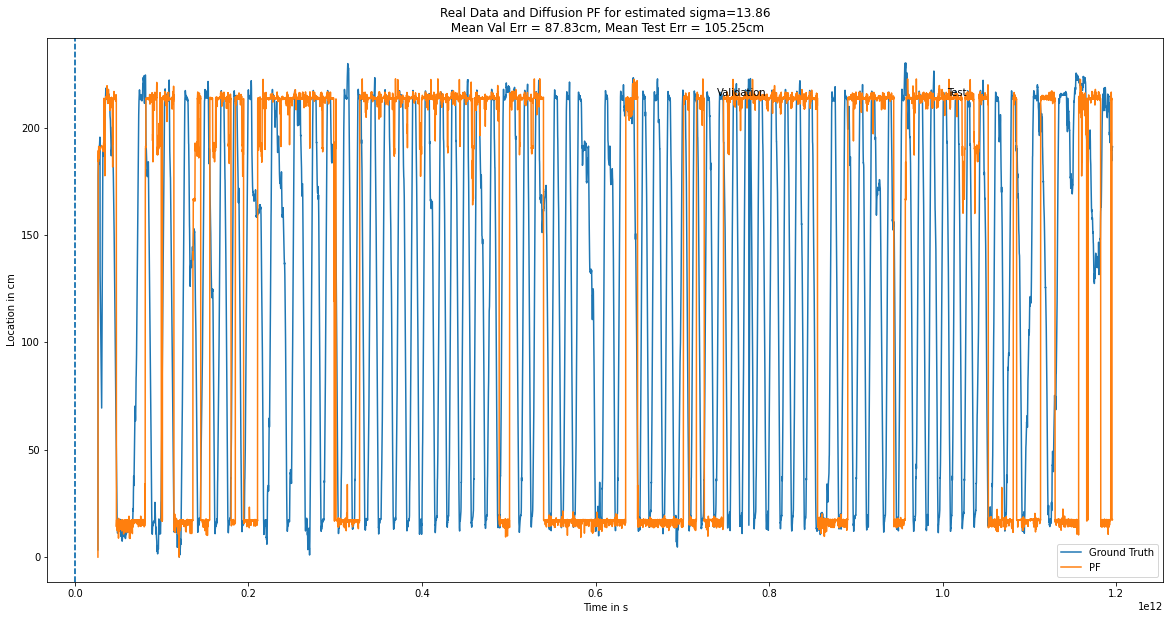

In [49]:
plt.plot(df.index,X)
plt.plot(df.index,mu)
plt.title("Real Data and Diffusion PF for estimated sigma={:.2f}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(sigma, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

In [26]:
# q_hat, tau_hat = fit_random_walk_model_no_boundaries(X_train, dt)
# params["q"] = q_hat
# params["tau"] = tau_hat

In [27]:
# x_pf, w_pf = random_walk_pf(spikes, params)

/Users/kushagrasharma/coding/drugo-lab/place-cell-reconstruction/filtering_algorithms.py:86: RuntimeWarning: invalid value encountered in true_divide
  w[i] /= np.sum(w[i])


In [28]:
# mu = np.sum(x_pf[:,0,:] * w_pf, 1)
# mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation).mean()
# mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test).mean()

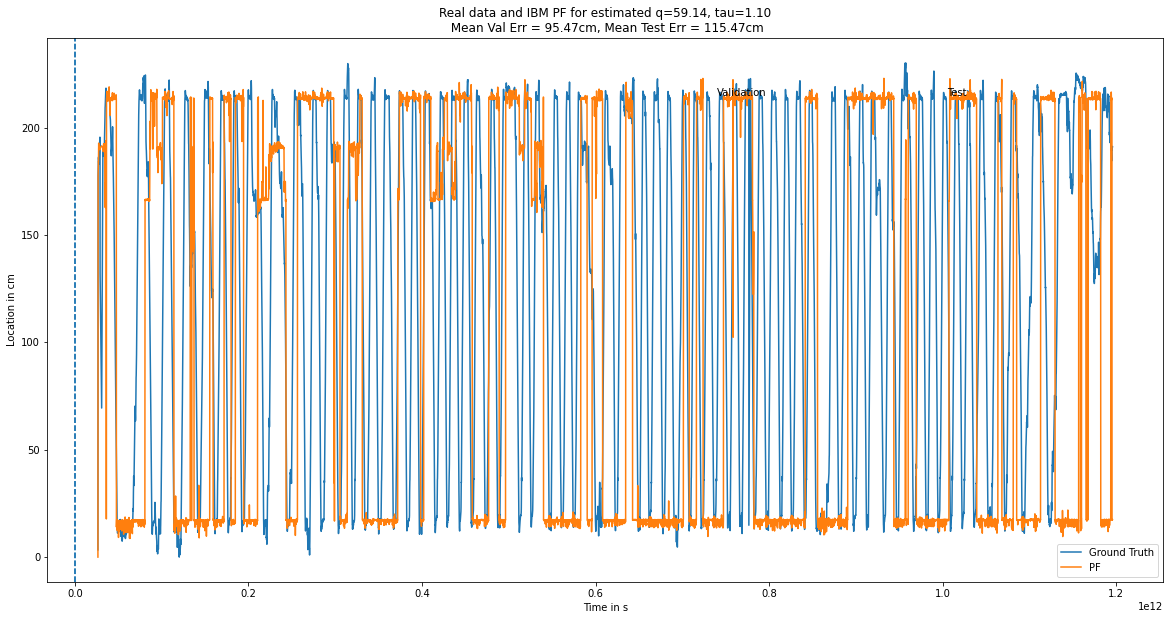

In [33]:
# plt.plot(df.index,X)
# plt.plot(df.index,mu)
# plt.title("Real data and IBM PF for estimated q={:.2f}, tau={:.2f}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(q_hat, tau_hat, mean_validation_err, mean_test_err))
# plt.legend(['Ground Truth', 'PF'])
# plt.ylabel("Location in cm") 
# plt.xlabel("Time in s")
# plt.axvline(len(X_train) * dt, ls='--')
# plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
# plt.figtext(0.59,0.8,"Validation")
# plt.figtext(0.75,0.8,"Test")
# plt.show()